In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


In [5]:
dir = 'data/'

train = pd.read_csv(dir+'train.csv')
test = pd.read_csv(dir+'test.csv')
submission = pd.read_csv(dir+'sample_submission.csv')

train.head()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1


In [6]:
train.info(), train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  10000 non-null  obje

(None, (10000, 15))

In [7]:
from sklearn.model_selection import train_test_split

X = train.drop(['user_id', 'target'], axis=1)
y = train.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class num_scaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ss = StandardScaler()

    def fit(self, X, y=None):
        self.ss.fit(X)
        return self 
    
    def transform(self, X, y=None):
        return self.ss.transform(X)

class label_scaler(BaseEstimator, TransformerMixin):
    def __init__(self, mapping):
        self.mapping = mapping

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X.map(self.mapping).values.reshape(-1, 1)
    
class ohe_scaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ohe = OneHotEncoder(sparse_output=False)

    def fit(self, X, y=None):
        self.ohe.fit(X.values.reshape(-1, 1))
        return self 
    
    def transform(self, X, y=None):
        return self.ohe.transform(X.values.reshape(-1, 1))

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
# 수치형에 왜 실수만 넣었냐?
# 요일 수 스케일링 해야하나? 일단 몰라서 passthrough
num_cols = X_train.select_dtypes('float').columns
label_cols = X_train.select_dtypes(exclude=[np.number]).columns[0]
ohe_cols = X_train.select_dtypes(exclude=[np.number]).columns[1]

mapping_difficulty = {'Low' : 0
					  ,'Medium' : 1
					  ,'High' : 2
					  }

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_scaler(), num_cols),
        ('label', label_scaler(mapping=mapping_difficulty), label_cols),
        ('ohe', ohe_scaler(), ohe_cols)
    ],
    remainder='passthrough'
)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])


In [10]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_validate
# 교차검증 
scoring = {
    'f1' : make_scorer(f1_score),
    'accuracy' : 'accuracy'
}

results = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=5)

In [11]:
# 교차검증표 저장
results_df = pd.DataFrame(results).round(3)
# results_df.to_csv('cv/basemodel_results_log.csv', index=False)

In [12]:
from sklearn import set_config
# set_config(display='diagram')
pipe.fit(X_train, y_train)

c:\Users\lys45\miniconda3\envs\lee\Lib\site-packages\sklearn\compose\_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', num_scaler(),
                                                  Index(['average_login_time', 'average_time_per_learning_session',
       'recent_learning_achievement'],
      dtype='object')),
                                                 ('label',
                                                  label_scaler(mapping={'High': 2,
                                                                        'Low': 0,
                                                                        'Medium': 1}),
                                                  'preferred_difficulty_level'),
                                                 ('ohe', ohe_scaler(),
                                                  'subscription_type')])),
                ('rf', RandomForestClassifier())])

In [13]:
from sklearn.inspection import permutation_importance
# permutation_importance? 피쳐 하나씩 뒤섞어서 망친 다음 중요도 평가
pi = permutation_importance(pipe, X_train, y_train, n_repeats=10, random_state=42, scoring='f1')

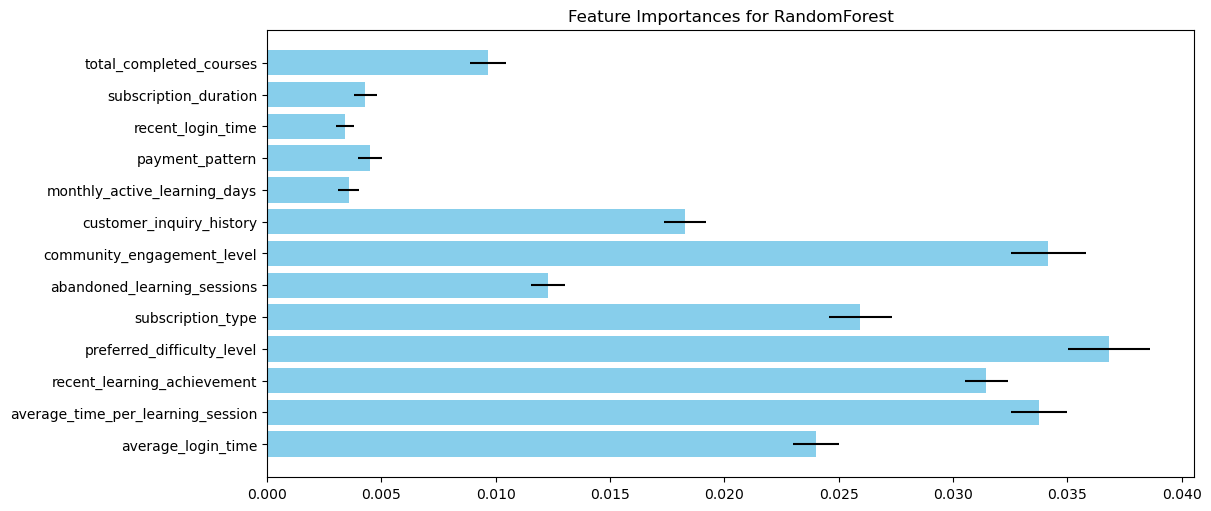

In [14]:
# 컬럼 순서대로 잘 불러오기!!
transformed_cols = list(num_cols) + [label_cols] + [ohe_cols]
left_behind_cols = X_train.columns.difference(transformed_cols)
feature_names = transformed_cols + list(left_behind_cols)

# feature importance
fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)
ax.barh(feature_names, pi.importances_mean, xerr=pi.importances_std, color='skyblue')
ax.set_title('Feature Importances for RandomForest')
plt.show()

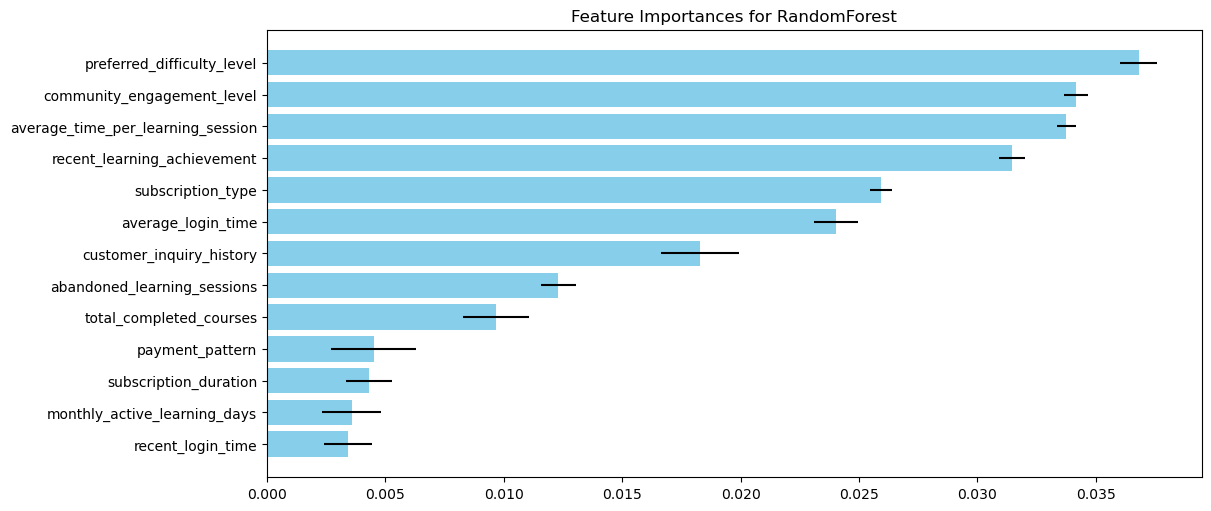

In [15]:
# feature importance 정렬
sorted_idx = pi.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)
ax.barh(np.array(feature_names)[sorted_idx], pi.importances_mean[sorted_idx],\
         xerr=pi.importances_std, color='skyblue')
ax.set_title('Feature Importances for RandomForest')
plt.show()